# SteerAI

SteerAI is our machine learning project to achieve the ambition of self-driving cars. The prospect of self-driving cars will improve the accessibility for blind, old and disabled people. So this our effort to contribute to this project.

We are working on this project as part of our Machine Learning (CSL-478) course in the graduation degree of Bachelor of Technology in Computer Science and Engineering. The project uses Convolutional Neural Network for classifying the images as **Straight**, **Left** or **Right**. We have used the following libraries in our project:-

| Library | Purpose |
| ------------- | ------------- |
| OpenCV  | For Image Analysis and Augmentation  |
| Tensorflow and Keras  | For building our Machine Learning model  |

### GitHub Repository

We have made our code open source. You can get it from our [GitHub Repository](https://github.com/ravgeetdhillon/steerAI). In case you have any doubts or issues, you can read our [project's Wiki](https://github.com/ravgeetdhillon/steerAI/wiki/Roadmap) as well.

### People

* [Ravgeet Dhillon](https://github.com/ravgeetdhillon)
* [Sharvan Sharma](https://github.com/sharvan-sharma)
* [Robin Kataria](https://github.com/robinkataria)
* [Rishi Raj](https://github.com/rishiraj4u)
* [Prateek Goyal](mailto:prateekgoyal@gmail.com)

# Creating the data

We created our dataset from the **NFS Most Wanted** 
environment. We have used [this python script](https://github.com/ravgeetdhillon/steerAI/blob/master/collectdata.py) to collect the data in the form of images and the keystrokes from the keyboard.

This script takes a screenshot and records a corresponding actions:- **straight**, **left** and **right**. We have uploaded our dataset on Google Drive.

In [0]:
'''
Import the data from Google Drive and mount it to Google Colab.
'''

from google.colab import drive
drive.mount('/content/drive')

In [0]:
'''
Importing the required libraries
'''

from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras import layers, models
from collections import Counter
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
import cv2

In [0]:
'''
Some important global variables used in the project.
'''

RESIZE = 0.5
EPOCHS = 20
LEARNING_RATE = 0.001

# Image Augmentation

Image Augmentation is a very important step in any Image Classification project. For humans, an image and its slightly contrasted image are the same things, but for a computer, they are two separate images. This is because a computer sees an image in the form of pixels rather than an image as a whole. Hence, augmenting the images give us two major advantages:-

* It helps us to create diverse conditions for image classification process.
* It helps in increasing our dataset which is always useful for a Machine Learning Model.

In this project, we choose images randomly and apply the following transformations on them:-

* **Cropping**:-
We crop the images till the horizon as we want our model to make predictions only based on the road ahead rather than the surrounding environment.
* **Horizontal Flip**:-
We flip the images horizontally and also reverse their labels except when the image label is **straight**.
* **Brightness and Contrast**:-
We adjust the brightness and contrast randomly to create diverse environments such as a brightened image depicts a sunny day whereas a darkened image depicts cloudy weather.

In [0]:
'''
Helper Functions for Image Analysis and Augmentation.
'''

def crop(image):
    '''
    Crops the image.
    '''
    
    image = image[120:260,]
    return image


def hflip(image):
    '''
    Flips the image horizontally.
    '''

    image = cv2.flip(image, 1)
    return image


def adjust_gamma(image):
    '''
    Alter the brightness and contrast of the image.
    '''

    gamma = np.random.uniform(0.5, 1.5)
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(image, table)


def gaussian_blur(image):
    '''
    Applies a Gaussian Noise kernel.
    '''

    kernel_size = 0
    while kernel_size % 2 == 0:
        kernel_size = np.random.randint(1, 6)
    image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return image


def hls(image):
    '''
    Converts RGB image to HSL image.
    '''

    image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    return image


def switch(label):
    '''
    Switches the label to the opposite one.
    '''

    if label == 'right':
        label = 'left'
    elif label == 'left':
        label = 'right'
    return label


def get_label(label):
    '''
    Returns integer equivalent of the label.
    '''

    if label == 'straight':
        label = 0
    elif label == 'left':
        label = 1
    elif label == 'right':
        label = 2
    return label


def get_data():
    '''
    Fetches the data from the Google Drive and distributes it into images and their respective labels.
    '''

    data = []
    parts = ['part1', 'part2']
    
    for part in parts:
        print(f'Fetching data from {part}')
        
        files = os.listdir(f'drive/My Drive/nfsmw/{part}/')
        for count, f in enumerate(files):
            
            if count % 50 == 0:
                print(f'Fetched {count} images and labels.')
            
            image = cv2.imread(f'/content/drive/My Drive/nfsmw/{part}/{f}')
            image = cv2.resize(image, None, fx=RESIZE, fy=RESIZE)
            image = crop(image)
            label = get_label(f.split('-')[1].split('.')[0])
            data.append( [image, label] )
            
            if np.random.randint(0, 2) == 0:
                image = hflip(image)
                label = switch(label)
                data.append( [image, get_label(label)] )
                
            if np.random.randint(0, 2) == 0:
                image = adjust_gamma(image)
                data.append( [image, get_label(label)] )

            if np.random.randint(0, 2) == 0:
                image = gaussian_blur(image)
                data.append( [image, get_label(label)] )

            if np.random.randint(0, 2) == 0:
                image = hls(image)
                data.append( [image, get_label(label)] )

    print(f'Generated {len(data)} images and labels from {len(parts)} parts.')
    return np.array(data)

# Preparing the data

We load our data from the Google Drive. To create randomness in the data, we shuffle it. A value of a pixel is represented in RGB format like (<0-255>,<0-255>,<0-255>). Hence, we normalize the images by scaling the pixel values to (<0-1>,<0-1>,<0-1>). We do this normalization by dividing the numpy array image vectors with 255. We separate the data into images and labels.

The model needs to be trained and tested as well. So we divide our dataset into **80%** training images for training the model and **20%** testing images for validating the model.

In [18]:
# fetch the data
data = get_data()

# shuffle the data to create some randomness
np.random.shuffle(data)

# normalize the images
images = np.array( [d[0] for d in data] )
images = images / 255.0

# get the labels for the images
labels = np.array( [d[1] for d in data] )

# divide the data into training and testing data
# keep the ratio at 80% to 20%
div = int( len(labels) * 0.8 )
train_images = images[:div]
train_labels = labels[:div]
test_images = images[div:]
test_labels = labels[div:]

Fetching data from part1
Fetched 0 images and labels.
Fetched 50 images and labels.
Fetched 100 images and labels.
Fetched 150 images and labels.
Fetched 200 images and labels.
Fetching data from part2
Fetched 0 images and labels.
Fetched 50 images and labels.
Fetched 100 images and labels.
Fetched 150 images and labels.
Fetched 200 images and labels.
Generated 1296 images and labels from 2 parts.


# Augmented Images

Below are some image from training set of images. All the images have been cropped till the horizon. After that some the images have been selected at random and the combination of horizontal flipping, brightness and contrast alternation.

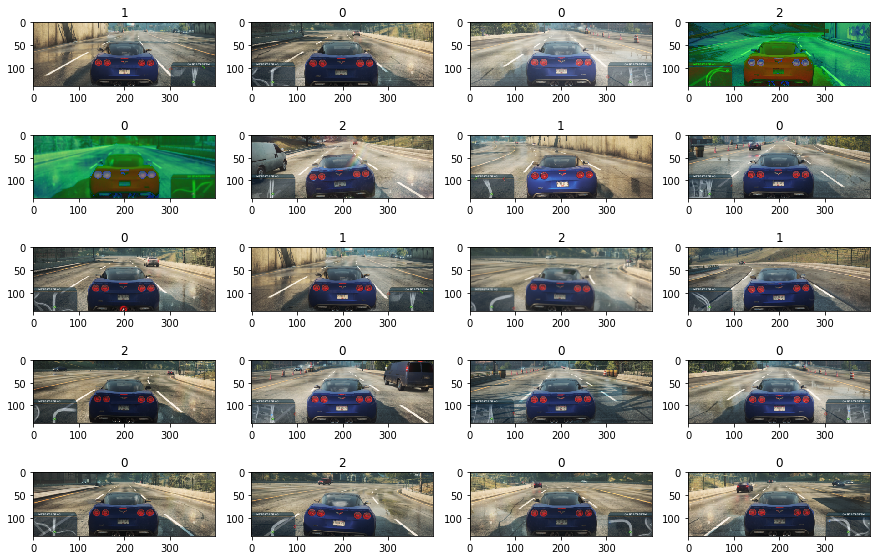

In [20]:
plt.figure( figsize=(15, 10) )
for i in range(20):
    plt.subplot(5, 4, i+1)
    plt.title(train_labels[i])
    plt.imshow(train_images[i][:,:,::-1])

# Convolutional Neural Network

![CNN Model Architecture for our SteerAI ](https://raw.githubusercontent.com/ravgeetdhillon/steerAI/colab/assets/sdc-model-architecture.png)

We have used the above-drawn architecture for our Convolutional Neural Network(CNN). We use the augmented images as an input to our Neural Network. The input shape of the image is **140x400x3**. It is passed through a **7x7 convolution layer**. To add nonlinearity to the model, we add a **ReLU activation layer**. It replaces the negative values in the output from the previous layer with 0. The next **3x3 MaxPooling** layer only keeps the highlighted features. After passing through this set of layers, the shape of the tensor reduces to **44x131x32**.

The reduced tensor is passed through a **5x5 convolution layer**. Again we add nonlinearity to the model, we add a **ReLU activation layer**. The next **2x2 MaxPooling** layer. After passing through this set of layers, the shape of the tensor reduces to **20x63x64**.

The reduced tensor is passed through a final **3x3 convolution layer**. We pass the model through a **ReLU activation layer** for the final time before introducing the fully connected layer in our model.

We then apply a flatten layer which reshapes the tensor into a single row vector. Then a fully connected **Dense** layer with **ReLU activation** is introduced which forms a neural network.

The model is compiled using **Adam** optimizer and loss is measured through **Sparse Categorical Cross Entropy**.

In [21]:
# get the input shape
input_shape = train_images[0].shape

print(f'Input Shape: {input_shape}')

# create a convolutional neural network base
model = models.Sequential(name='sdc_cnn_model')

model.add(layers.Conv2D(32, (7, 7), input_shape=input_shape, name='first_conv2d_7'))
model.add(layers.Activation('relu', name='first_activation'))
model.add(layers.MaxPooling2D((3, 3), name='first_maxpooling_3'))

model.add(layers.Conv2D(64, (5, 5), name='second_conv2d_5'))
model.add(layers.Activation('relu', name='second_activation'))
model.add(layers.MaxPooling2D((2, 2), name='second_maxpooling_2'))

model.add(layers.Conv2D(128, (3, 3), name='third_conv2d_3'))
model.add(layers.Activation('relu', name='third_activation'))

# add dense layers on the top
model.add(layers.Flatten(name='flatten_layer'))
model.add(layers.Dense(64, activation='relu', name='first_dense'))
model.add(layers.Dense(3, activation='softmax', name='softmax_layer'))

# get the model's summary to validate the model architecture
model.summary()

# compile and train the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

# save the model
model.save('sdc-cnn-model.h5')

Input Shape: (140, 400, 3)
Model: "sdc_cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first_conv2d_7 (Conv2D)      (None, 134, 394, 32)      4736      
_________________________________________________________________
first_activation (Activation (None, 134, 394, 32)      0         
_________________________________________________________________
first_maxpooling_3 (MaxPooli (None, 44, 131, 32)       0         
_________________________________________________________________
second_conv2d_5 (Conv2D)     (None, 40, 127, 64)       51264     
_________________________________________________________________
second_activation (Activatio (None, 40, 127, 64)       0         
_________________________________________________________________
second_maxpooling_2 (MaxPool (None, 20, 63, 64)        0         
_________________________________________________________________
third_conv2d_3 (Conv2D)   

# Evaluating the model

We plot the graphs to evaluate the performance of our model. We can see that our model starts to **overfit** after 15 epochs. Hence, we can reduce the number of `EPOCHS` to 15 and get an appreciable accuracy of 98.7%

The current accuracy means that, if this self-driving car is put on roads, then there will 13 accidents in every 1000 events. This is certainly not acceptable as we have to develop a foolproof system for our self-driving cars. By doing more changes to the model we can increase the accuracy to some extent.

260/260 - 1s - loss: 0.1665 - acc: 0.9769
Accuracy: 0.9769230484962463, Loss: 0.16647383836924956


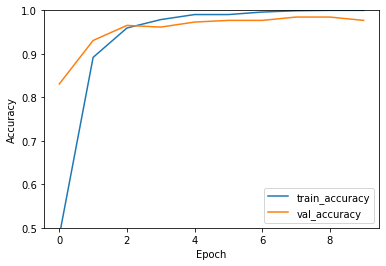

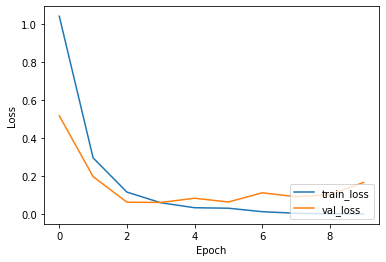

In [24]:
# evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print(f'Accuracy: {test_acc}, Loss: {test_loss}')

plt.plot( history.history['acc'], label='train_accuracy' )
plt.plot( history.history['val_acc'], label = 'val_accuracy' )
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim( [0.5, 1] )
plt.legend(loc='lower right')
plt.show()

plt.plot( history.history['loss'], label='train_loss' )
plt.plot( history.history['val_loss'], label = 'val_loss' )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()